# 2. Detecting facial expressions from images

*Written by Jin Hyun Cheong and Eshin Jolly*

In this tutorial we'll explore the `Detector` class in more depth, demonstrating how to detect faces, facial landmarks, action units, and emotions from images. You can try it out interactively in Google Collab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cosanlab/py-feat/blob/master/notebooks/content/02_detector_imgs.ipynb)

In [ ]:
# Uncomment the line below and run this only if you're using Google Collab
# !pip install -q py-feat

## 2.1 Detecting a single face from a single image

### Setting up the Detector

When using the `Detector` you can either specify specific models to use or just load the default models which are defined explicitly below:

In [1]:
from feat import Detector

detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
)

detector

feat.detector.Detector(face_model=retinaface, landmark_model=mobilefacenet, au_model=xgb, emotion_model=resmasknet, facepose_model=img2pose)

Let's process a single image with a single face. Py-feat includes a demo image for this purpose called `single_face.jpg` so lets use that. You can also use the convenient `imshow` function which will automatically load an image into a numpy array if provided a path unlike matplotlib:

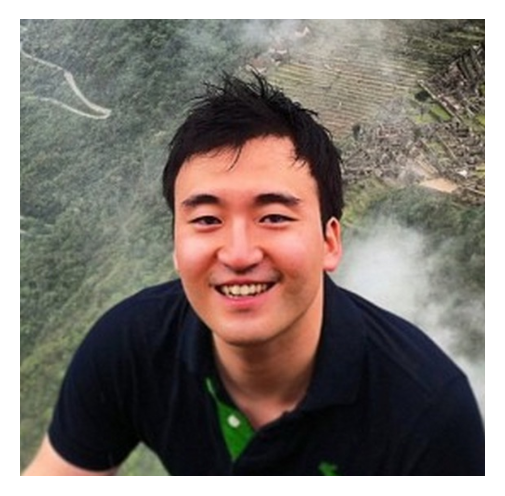

In [2]:
from feat.utils.io import get_test_data_path
from feat.plotting import imshow
import os

# Helper to point to the test data folder
test_data_dir = get_test_data_path()

# Get the full path
single_face_img_path = os.path.join(test_data_dir, "single_face.jpg")

# Plot it
imshow(single_face_img_path)

Now we use our initialized `detector` instance to make predictions with the `detect_image()` method. This is the main workhorse method that will perform face, landmark, au, and emotion detection using the loaded models. It always returns a `Fex` data instance:

In [3]:
single_face_prediction = detector.detect_image(single_face_img_path)

# Show results
single_face_prediction

100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


FaceRectX  FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
0  192.561653  140.51021      179.37261      259.209973   0.999708   

          x_0         x_1         x_2         x_3         x_4  ...      AU43  \
0  186.658539  187.411811  189.165036  193.472231  202.410419  ...  0.277524   

      anger   disgust      fear  happiness   sadness  surprise   neutral  \
0  0.000495  0.000025  0.001946   0.990421  0.000028  0.007057  0.000029   

                                               input  frame  
0  /Users/Esh/Documents/pypackages/py-feat/feat/t...      0  

[1 rows x 173 columns]

### Working with Fex data class results

Because the output is a `Fex` data class instance, we can utilize its various helper methods and attributes to inspect our predictions.

#### Easily accessing FEX columns of interest.  

Fex data classes make it simple to access various columns of interest (AUs, emotion, faceboxes, etc): 

In [4]:
single_face_prediction.facebox

FaceRectX  FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore
0  192.561653  140.51021      179.37261      259.209973   0.999708

In [5]:
single_face_prediction.aus

AU01      AU02      AU04      AU05      AU06  AU07      AU09      AU10  \
0  0.360115  0.472855  0.508774  0.290168  0.775952   0.0  0.550643  0.982302   

       AU11      AU12      AU14      AU15    AU17  AU20      AU23      AU24  \
0  0.500063  0.880451  0.597636  0.181066  0.2801   1.0  0.326927  0.339884   

       AU25      AU26      AU28      AU43  
0  0.996584  0.276738  0.025107  0.277524

In [6]:
single_face_prediction.emotions

anger   disgust      fear  happiness   sadness  surprise   neutral
0  0.000495  0.000025  0.001946   0.990421  0.000028  0.007057  0.000029

In [7]:
single_face_prediction.facepose # (in degrees)

Pitch      Roll       Yaw
0  0.863918 -3.837977  6.635625

#### Saving detection to a file

Since a `Fex` object is just a sub-classed `DataFrames` we can use the `.to_csv` method to save our detections toa file:

In [8]:
single_face_prediction.to_csv("output.csv", index=False)

#### Loading detection results from a saved file

We can load this output using the `read_feat()` function, which behaves just like `pd.read_csv` from Pandas, but returns a `Fex` data class instead of a DataFrame. This gives you the full suite of Fex funcionality right away.

In [9]:
# prefer to pandas read_csv
from feat.utils.io import read_feat

input_prediction = read_feat("output.csv")

# Show results
input_prediction

FaceRectX  FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
0  192.561653  140.51021      179.37261      259.209973   0.999708   

          x_0         x_1         x_2         x_3         x_4  ...      AU43  \
0  186.658539  187.411811  189.165036  193.472231  202.410419  ...  0.277524   

      anger   disgust      fear  happiness   sadness  surprise   neutral  \
0  0.000495  0.000025  0.001946   0.990421  0.000028  0.007057  0.000029   

        input  frame  
0  output.csv      0  

[1 rows x 173 columns]

#### Visualizing detection results.

We can use the `.plot_detections()` method to generate a summary figure of detected faces, action units and emotions. It always returns a list of matplotlib figures:

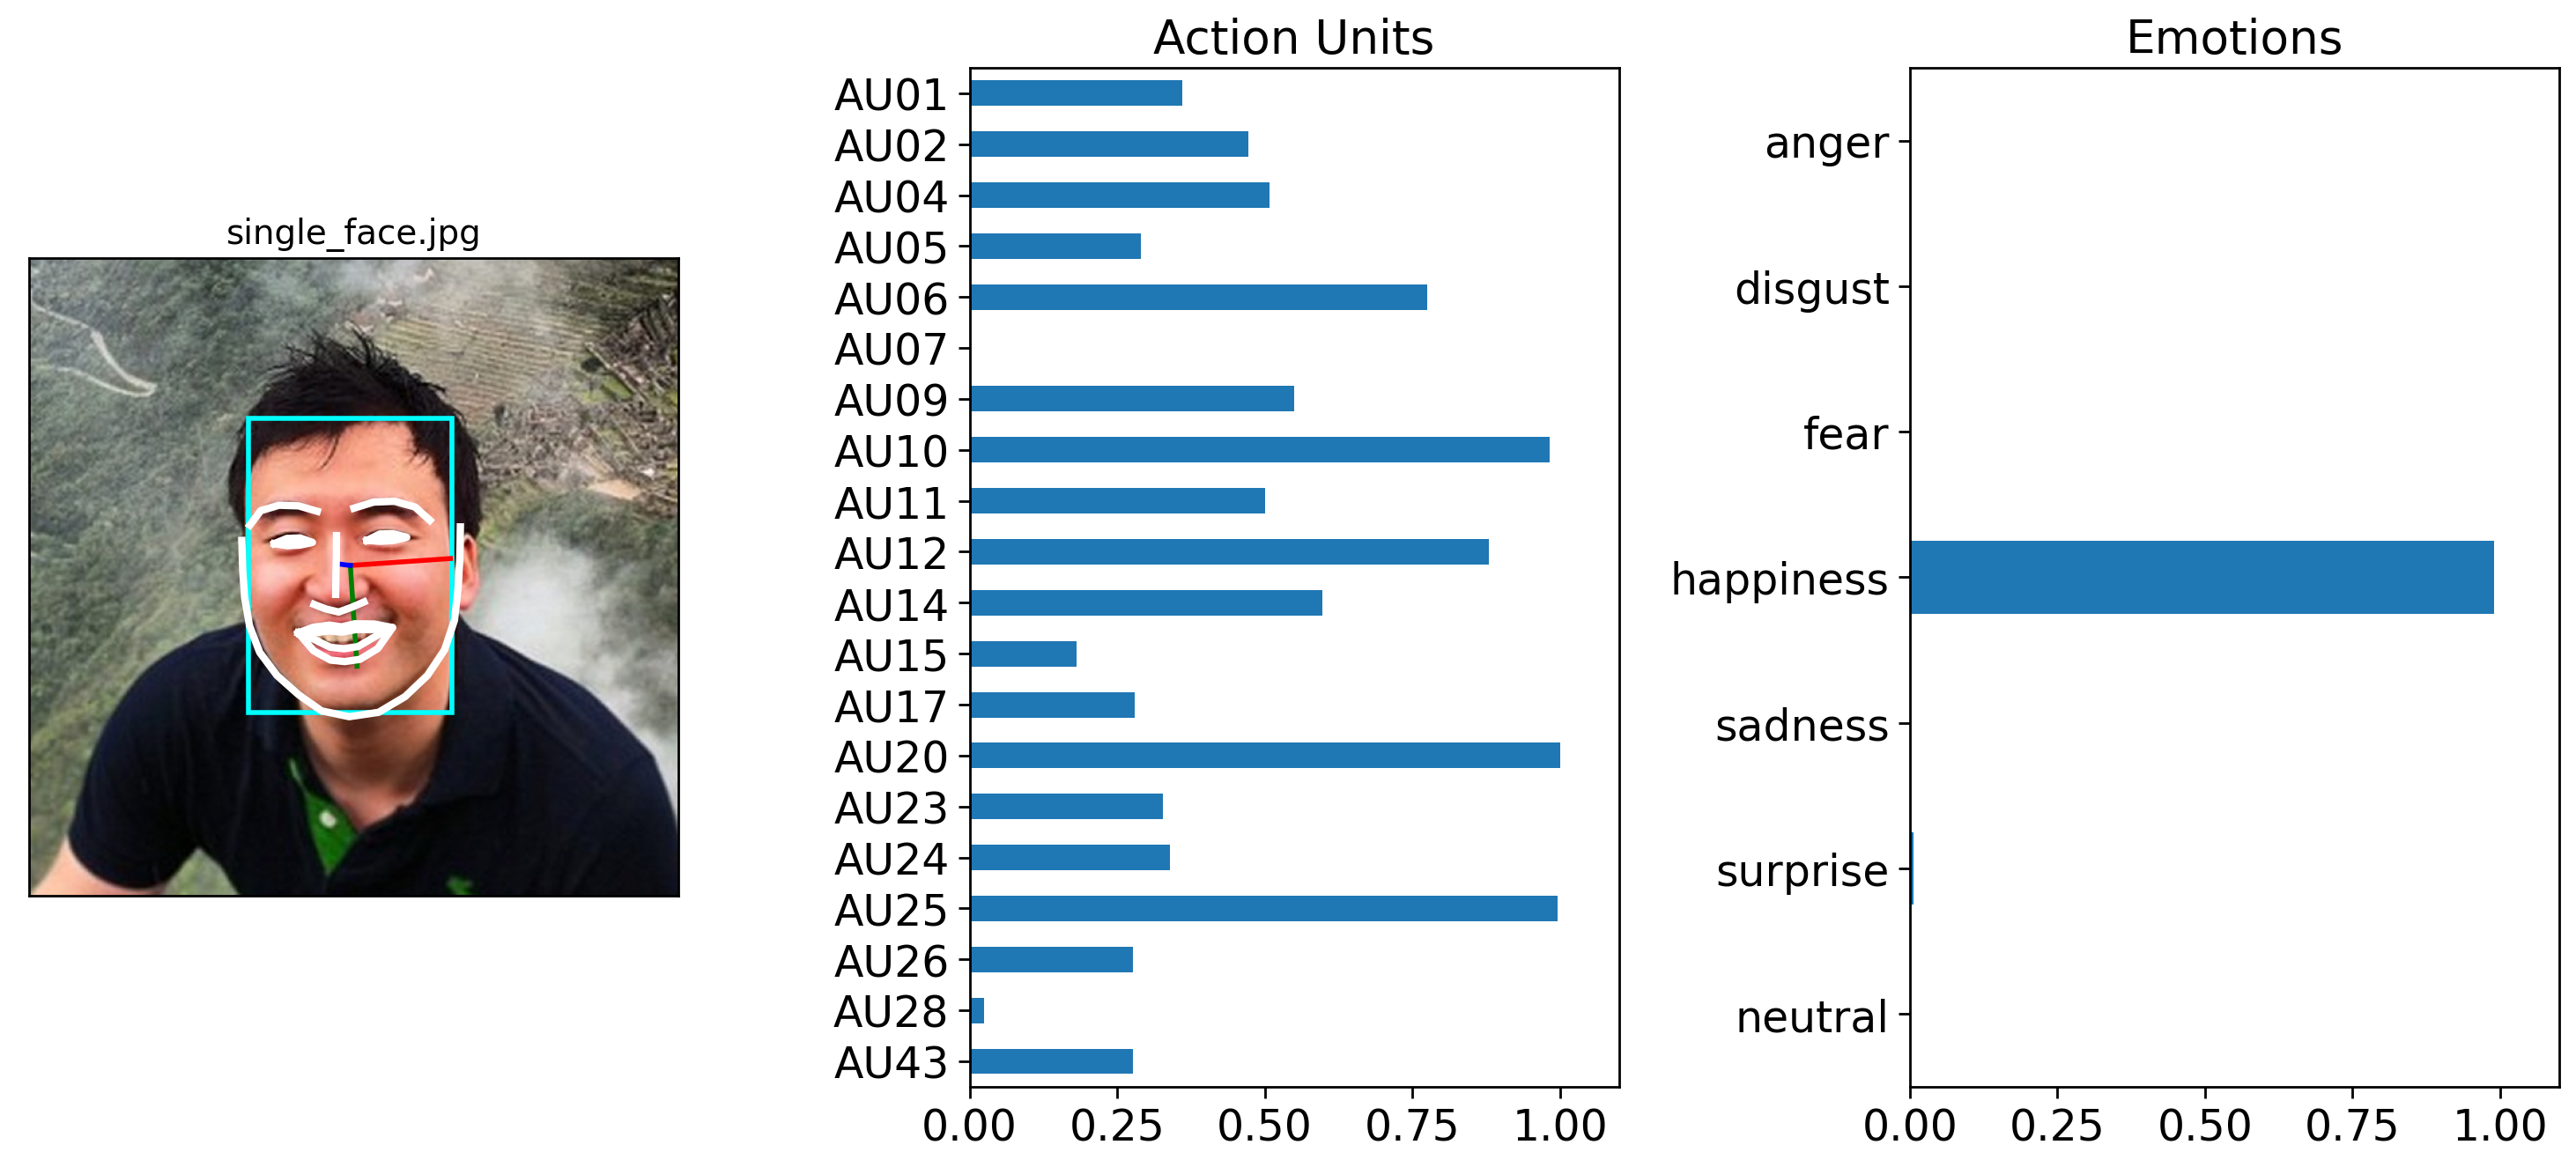

In [10]:
figs = single_face_prediction.plot_detections(poses=True)

By default `.plot_detections()` will overlay facial lines on top of the input image. However, it's also possible to visualize a face using Py-Feat's standardized AU landmark model, which takes the detected AUs and projects them onto a template face. You an control this by change by setting `faces='aus'` instead of the default `faces='landmarks'`. For more details about this kind of visualization see the [visualizing facial expressions](./04_plotting.ipynb) and the [creating an AU visualization model](../extra_tutorials/06_trainAUvisModel.ipynb) tutorials:

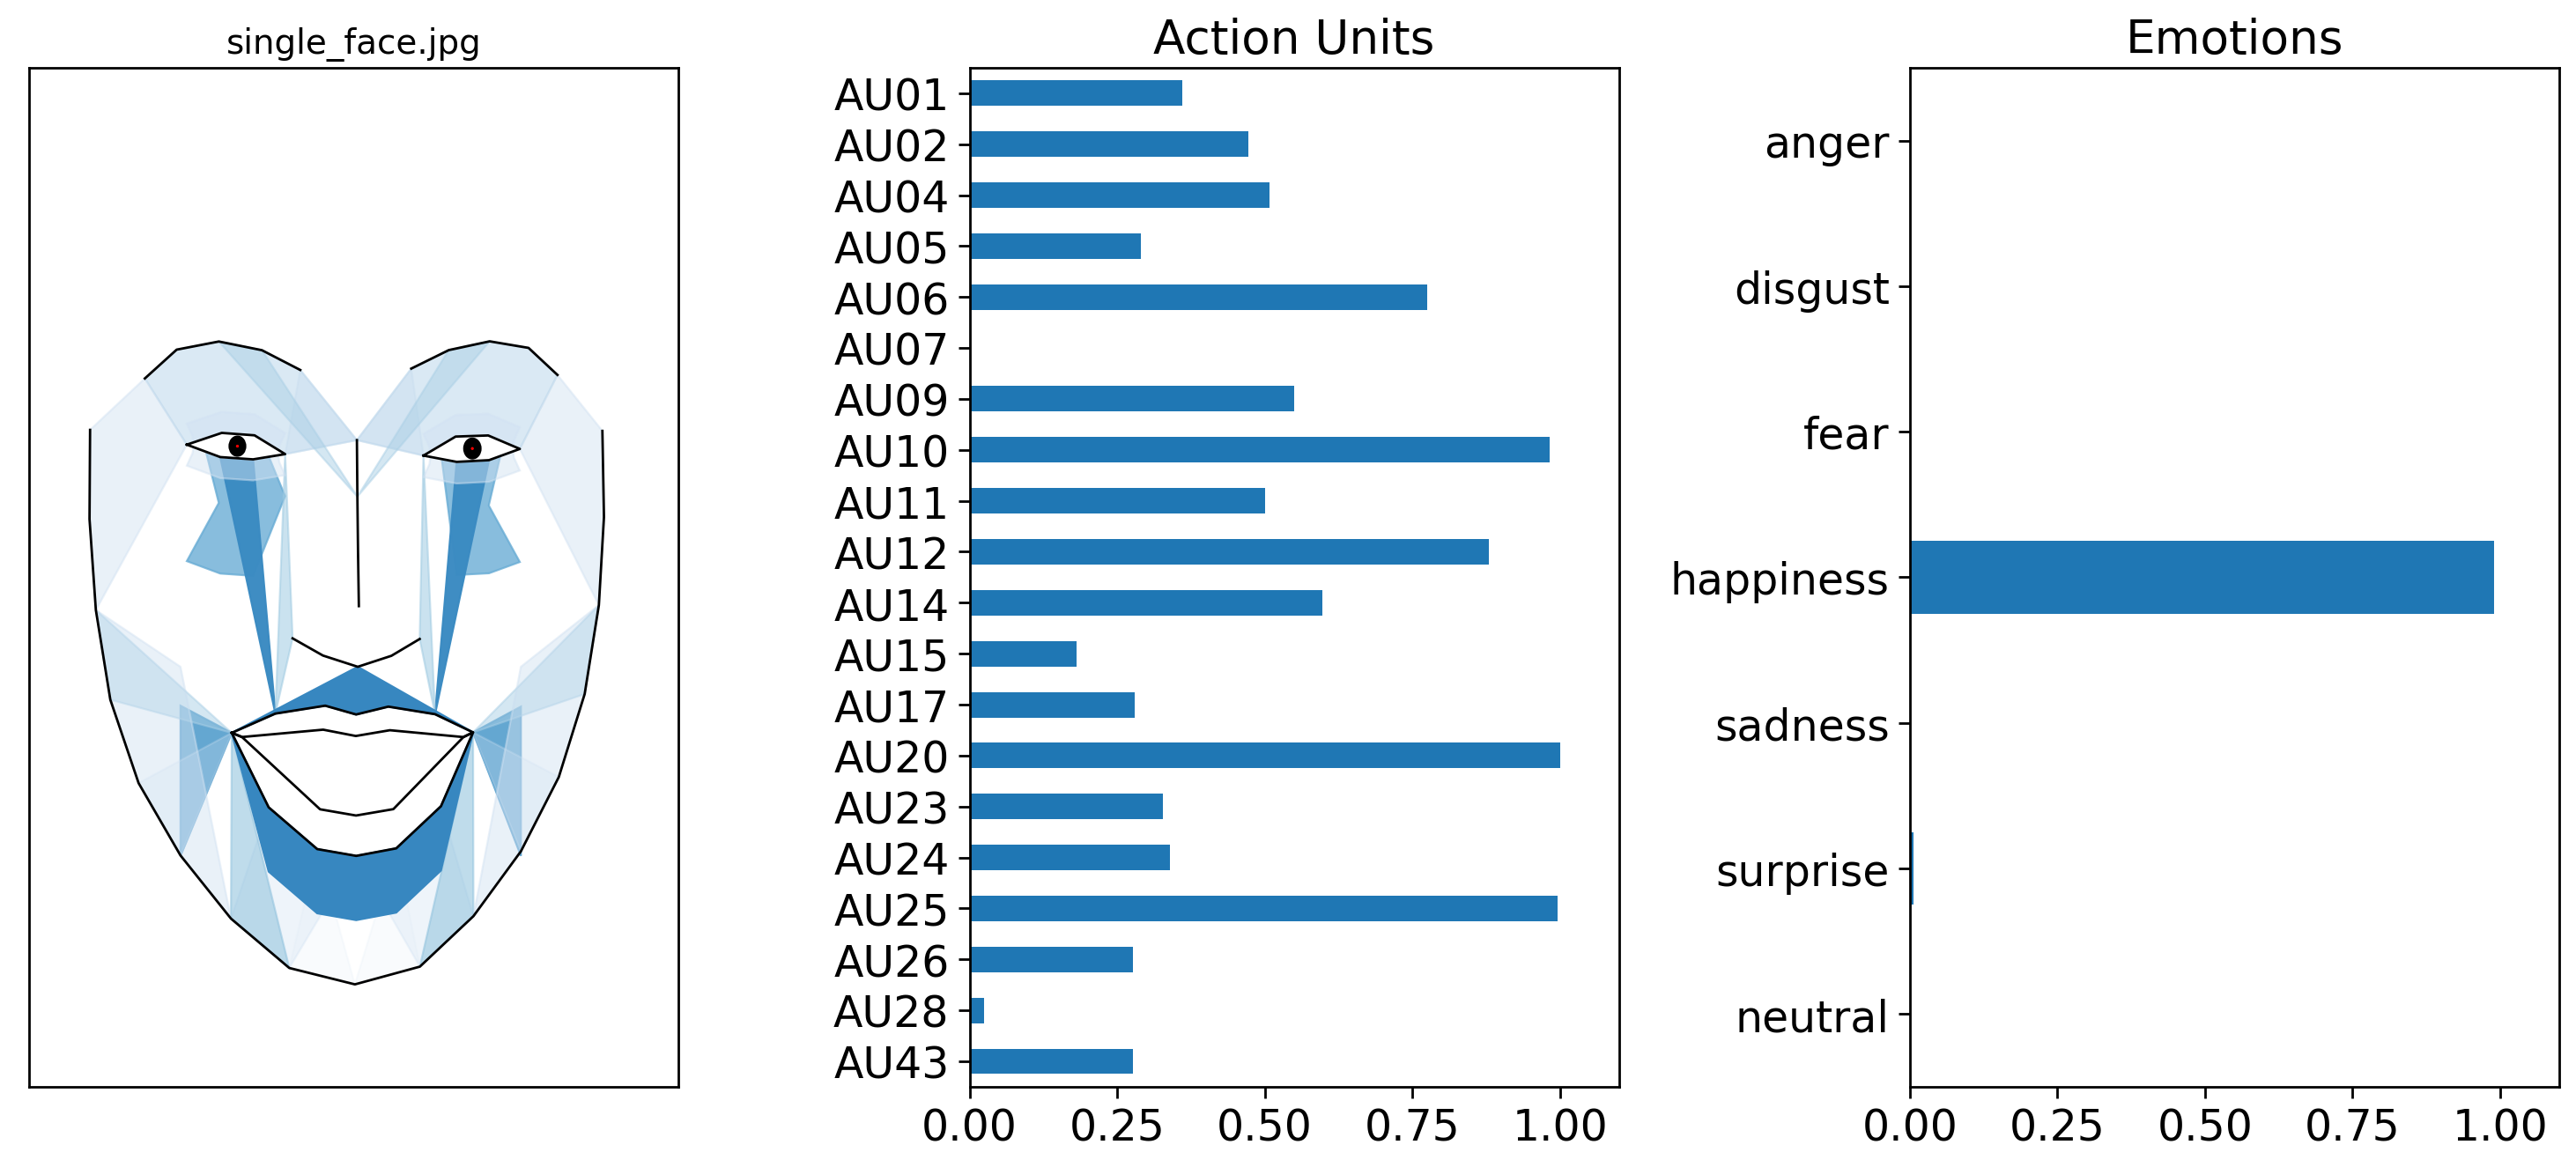

In [11]:
figs = single_face_prediction.plot_detections(faces='aus', muscles=True)

## 2.2 Detecting multiple faces from a single image 

A `Detector` can automatically find multiple faces in a single image. We'll see that in the next example, the number of rows of the Fex data class returned from `.detect_image()` has one row for each detected face. We'll also try using a different model this time, Img2Pose, which acts as both a face detector and a face pose estimator.

Notice how `image_prediction` is now a Fex instance with 5 rows, one for each detected face. We can confirm this by plotting our detection results and poses like before:

In [12]:
multi_face_image_path = os.path.join(test_data_dir, "multi_face.jpg")
multi_face_prediction = detector.detect_image(multi_face_image_path)

# Show results
multi_face_prediction

100%|██████████| 1/1 [00:08<00:00,  8.47s/it]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
0  683.335838  288.563033     105.395773      134.118132   0.999814   
1  531.734346  309.172962      97.299739      123.768050   0.999358   
2  316.659267  236.801834      91.554931      120.343772   0.998964   
3  435.008585  211.011886      82.006314      101.065502   0.994463   
4  219.923669   64.624866      85.467177      111.225995   0.994245   

          x_0         x_1         x_2         x_3         x_4  ...      AU43  \
0  685.494912  683.336467  682.095127  682.703083  686.400650  ...  0.170883   
1  533.901843  532.174873  531.632657  532.337446  535.039510  ...  0.529417   
2  313.344974  314.485803  316.831155  320.896162  327.509244  ...  0.171810   
3  436.149135  437.005833  438.491356  440.477046  443.712133  ...  0.109600   
4  219.396966  217.687955  216.776542  217.055890  219.865002  ...  0.067352   

      anger   disgust      fear  happiness   sadness  surprise   neutral  \
0  0.000317  0.003644  0.000119   0.992836  0.000292  0.002569  0.000223   
1  0.000201  0.000161  0.000089   0.999188  0.000092  0.000251  0.000019   
2  0.000062  0.000046  0.000080   0.991157  0.000029  0.008593  0.000033   
3  0.013225  0.008497  0.000090   0.039161  0.005604  0.003555  0.929868   
4  0.000050  0.005056  0.000147   0.992222  0.000013  0.002488  0.000025   

                                               input  frame  
0  /Users/Esh/Documents/pypackages/py-feat/feat/t...      0  
1  /Users/Esh/Documents/pypackages/py-feat/feat/t...      0  
2  /Users/Esh/Documents/pypackages/py-feat/feat/t...      0  
3  /Users/Esh/Documents/pypackages/py-feat/feat/t...      0  
4  /Users/Esh/Documents/pypackages/py-feat/feat/t...      0  

[5 rows x 173 columns]

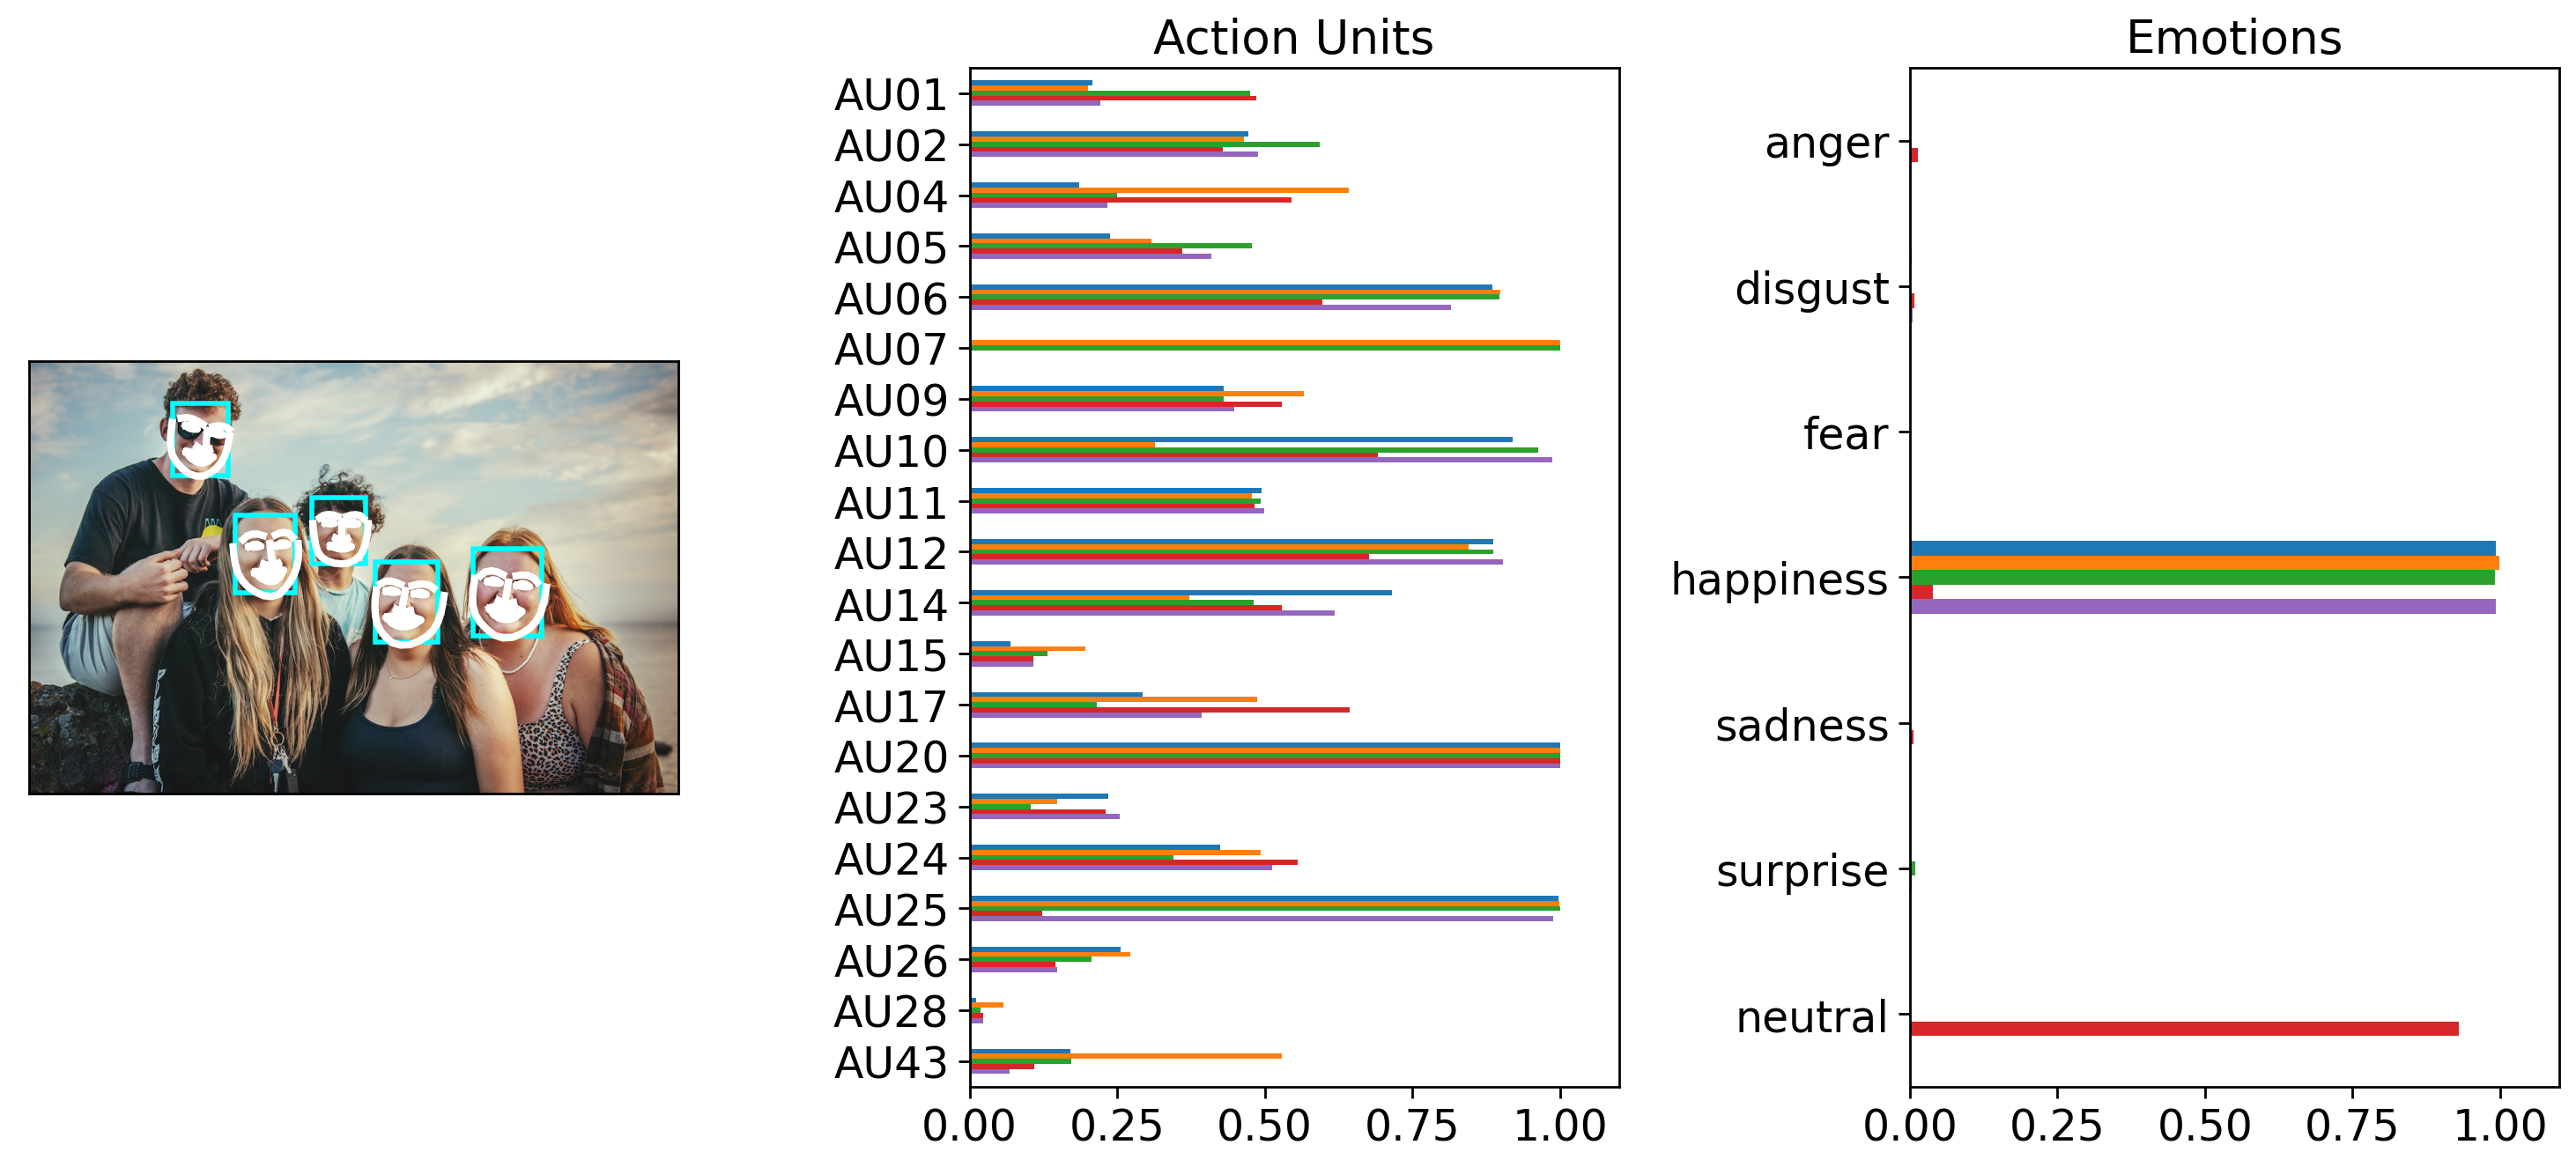

In [13]:
figs = multi_face_prediction.plot_detections(add_titles=False)

## 2.3 Detecting faces from multiple images

`Detector` is also flexible enough to process multiple image files if `.detect_image()` is passed a list of images. By default images will be processed serially, but you can set `batch_size > 1` to process multiple images in a *batch* and speed up processing. **NOTE: All images in a batch must have the same dimensions for batch processing.** This is because behind the scenes, `Detector` is assembling a *tensor* by stacking images together. You can ask `Detector` to rescale images by padding and preserving proportions using the `output_size` in conjunction with `batch_size`. For example, the following would process a list of images in batches of 5 images at a time resizing each so one axis is 512:

`detector.detect_image(img_list, batch_size=5, output_size=512) # without output_size this would raise an error if image sizes differ!`

In the example below we keep things simple, by process both our single and multi-face example serislly by setting `batch_size = 1`.

Notice how the returned Fex data class instance has 6 rows: 1 for the first face in the first image, and 5 for the faces in the second image:

In [14]:
img_list = [single_face_img_path, multi_face_image_path]

mixed_prediction = detector.detect_image(img_list, batch_size=1)
mixed_prediction

100%|██████████| 2/2 [00:12<00:00,  6.20s/it]


FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore  \
0  192.561653  140.510210     179.372610      259.209973   0.999708   
1  683.335838  288.563033     105.395773      134.118132   0.999814   
2  531.734346  309.172962      97.299739      123.768050   0.999358   
3  316.659267  236.801834      91.554931      120.343772   0.998964   
4  435.008585  211.011886      82.006314      101.065502   0.994463   
5  219.923669   64.624866      85.467177      111.225995   0.994245   

          x_0         x_1         x_2         x_3         x_4  ...      AU43  \
0  186.658539  187.411811  189.165036  193.472231  202.410419  ...  0.277524   
1  685.494912  683.336467  682.095127  682.703083  686.400650  ...  0.170883   
2  533.901843  532.174873  531.632657  532.337446  535.039510  ...  0.529417   
3  313.344974  314.485803  316.831155  320.896162  327.509244  ...  0.171810   
4  436.149135  437.005833  438.491356  440.477046  443.712133  ...  0.109600   
5  219.396966  217.687955  216.776542  217.055890  219.865002  ...  0.067352   

      anger   disgust      fear  happiness   sadness  surprise   neutral  \
0  0.000495  0.000025  0.001946   0.990421  0.000028  0.007057  0.000029   
1  0.000317  0.003644  0.000119   0.992836  0.000292  0.002569  0.000223   
2  0.000201  0.000161  0.000089   0.999188  0.000092  0.000251  0.000019   
3  0.000062  0.000046  0.000080   0.991157  0.000029  0.008593  0.000033   
4  0.013225  0.008497  0.000090   0.039161  0.005604  0.003555  0.929868   
5  0.000050  0.005056  0.000147   0.992222  0.000013  0.002488  0.000025   

                                               input  frame  
0  /Users/Esh/Documents/pypackages/py-feat/feat/t...      0  
1  /Users/Esh/Documents/pypackages/py-feat/feat/t...      1  
2  /Users/Esh/Documents/pypackages/py-feat/feat/t...      1  
3  /Users/Esh/Documents/pypackages/py-feat/feat/t...      1  
4  /Users/Esh/Documents/pypackages/py-feat/feat/t...      1  
5  /Users/Esh/Documents/pypackages/py-feat/feat/t...      1  

[6 rows x 173 columns]

Calling `.plot_detections()` will now plot detections for all images the detector was passed:

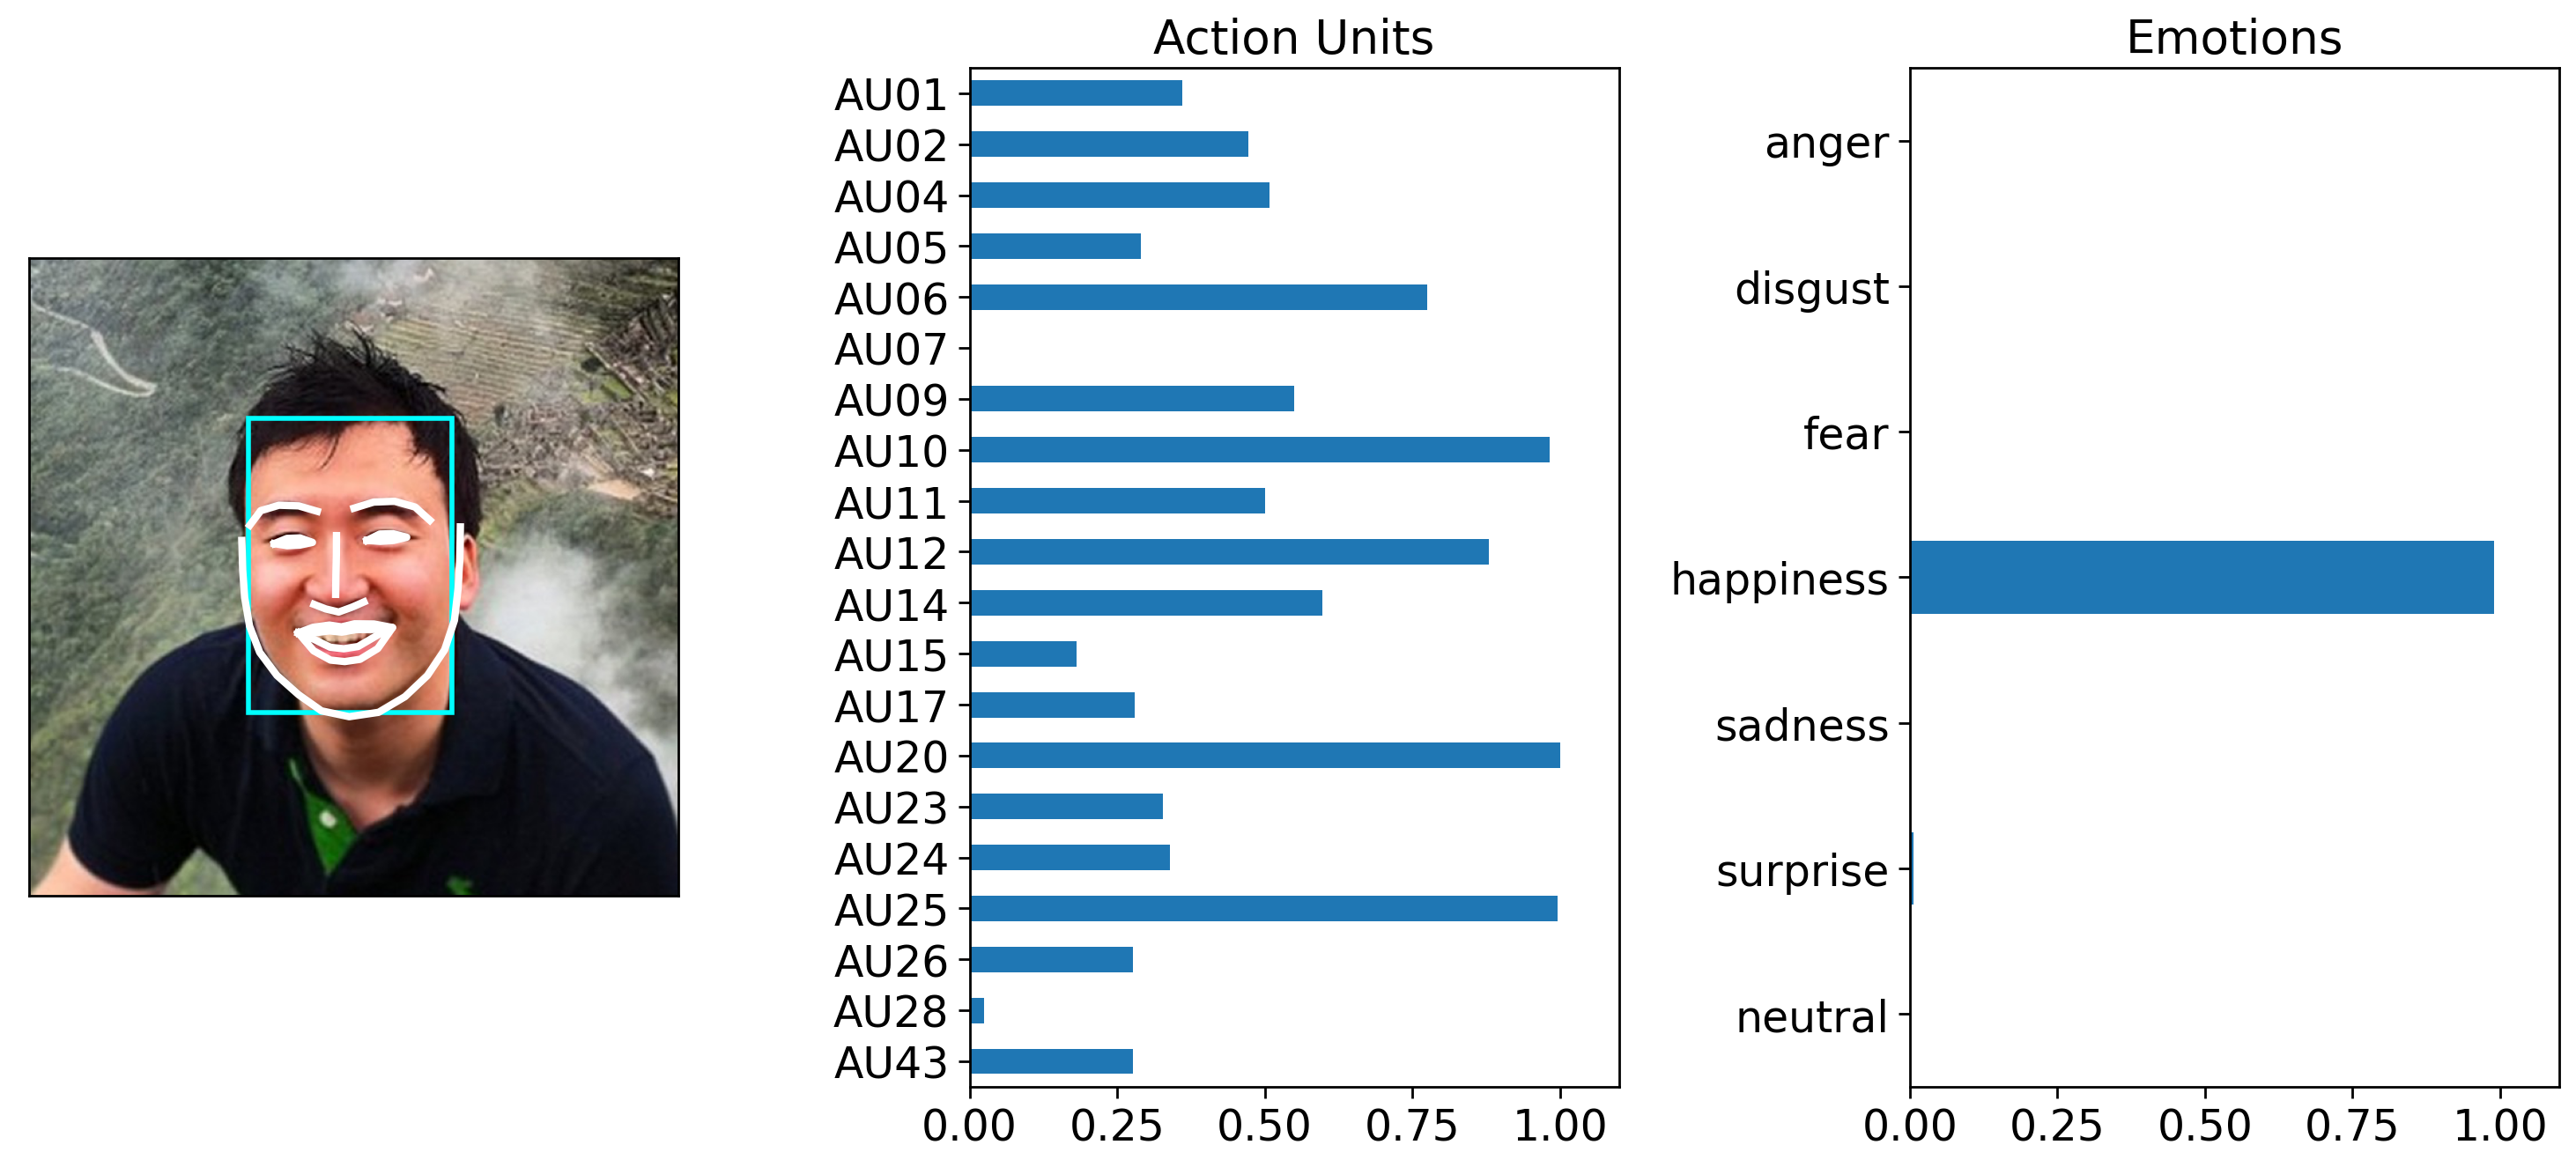

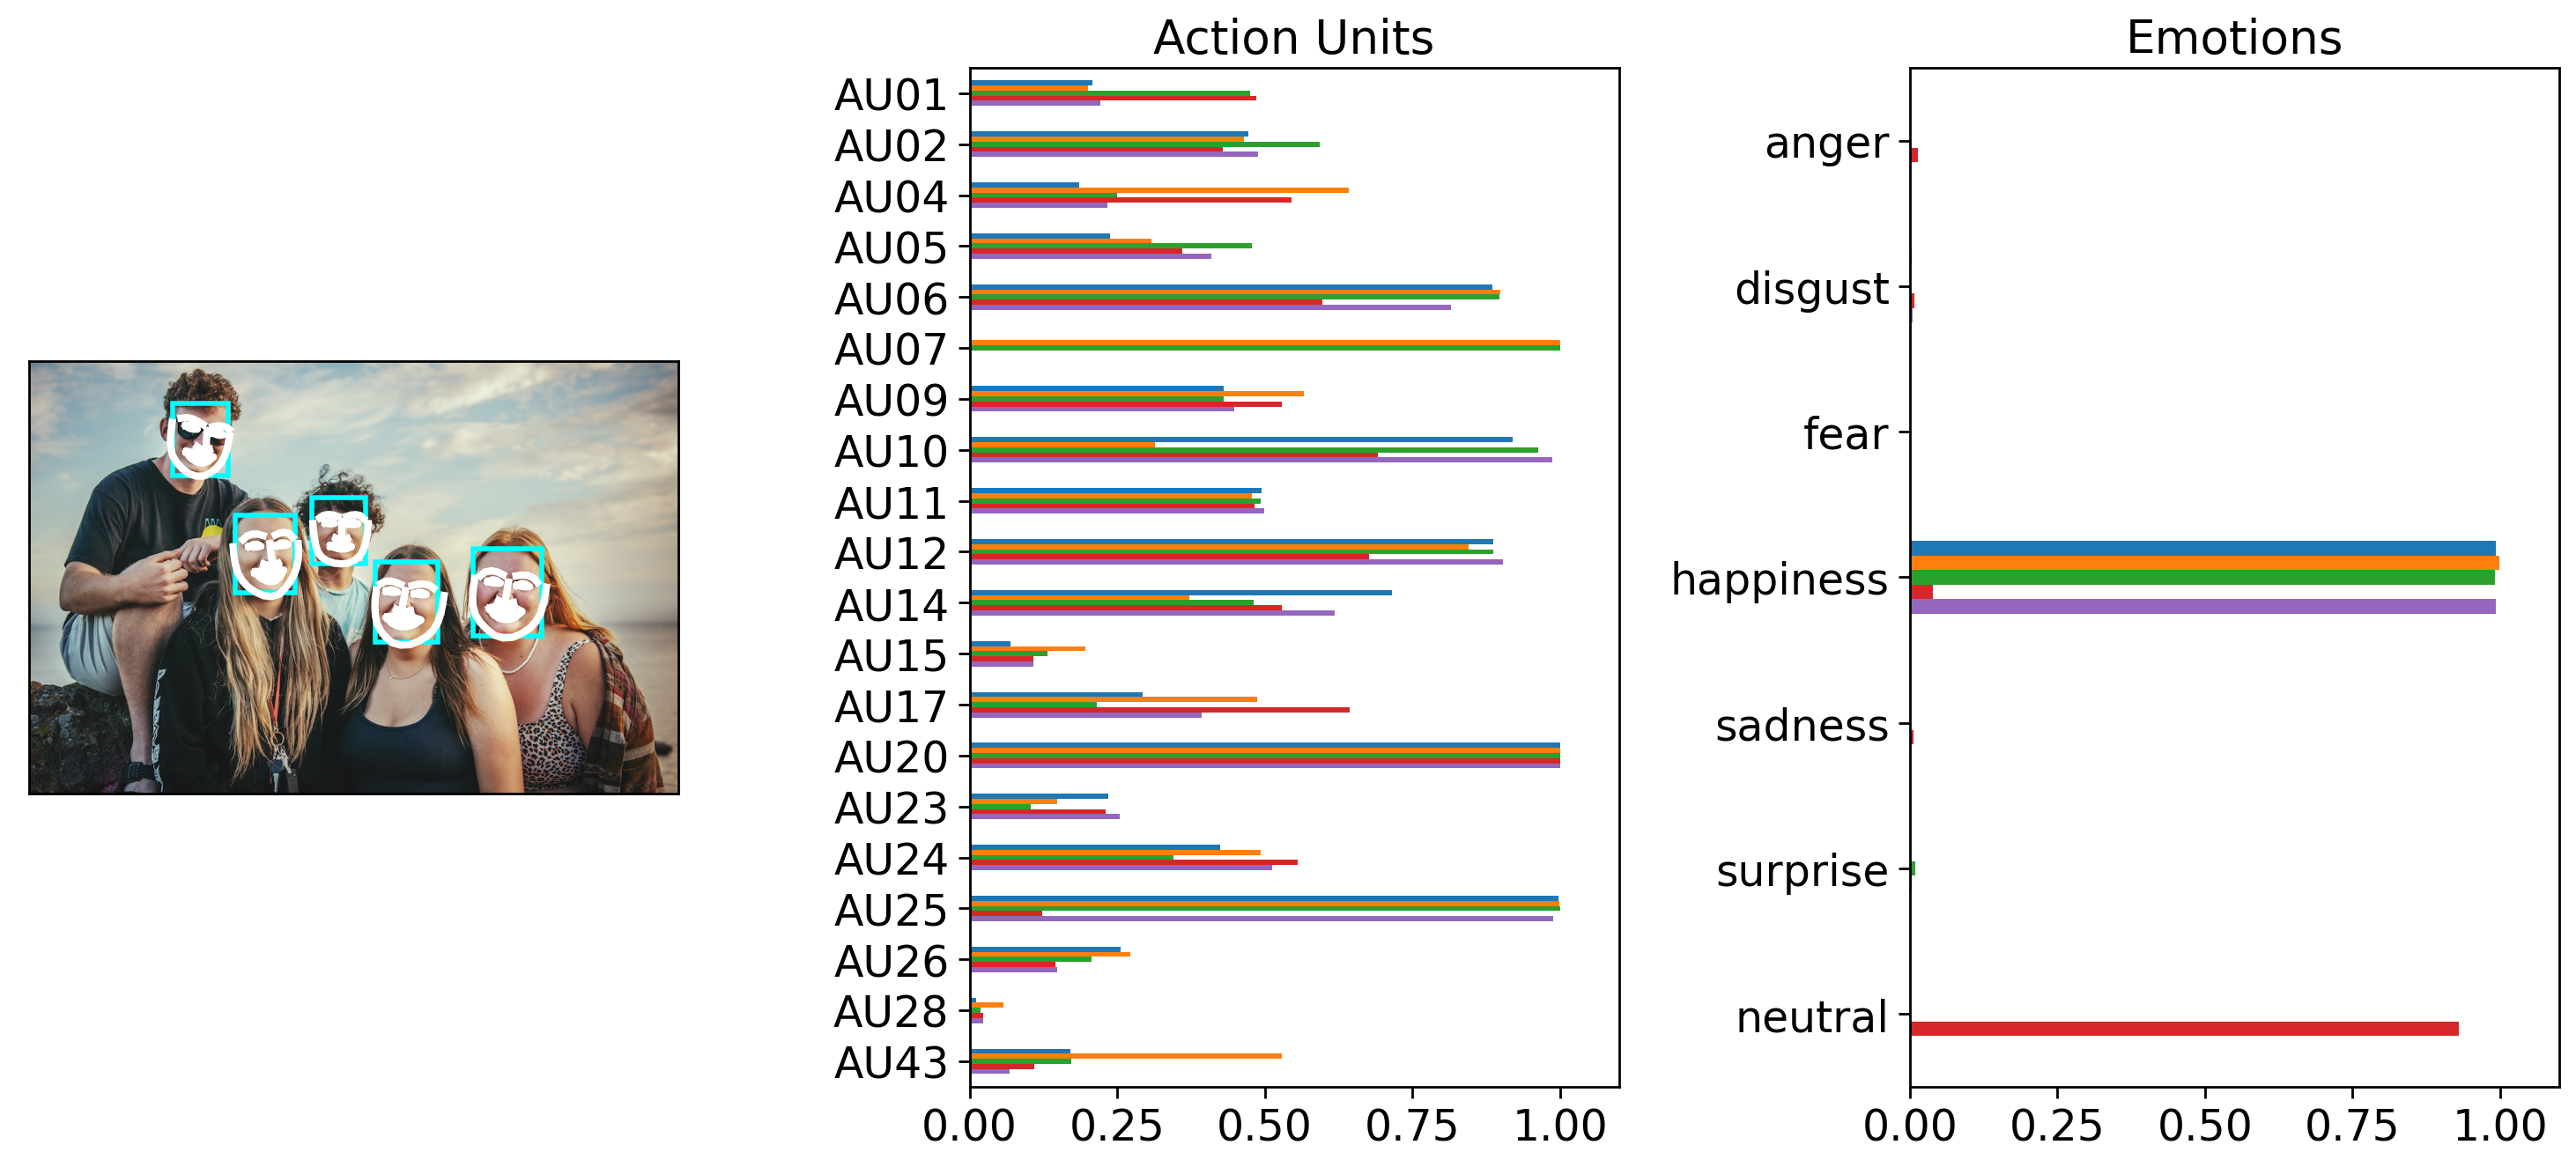

In [15]:
figs = mixed_prediction.plot_detections(add_titles=False)

However, it's easy to use pandas slicing sytax to just grab predictions for the image you want. For example you can use `.loc` and chain it to `.plot_detections()`:

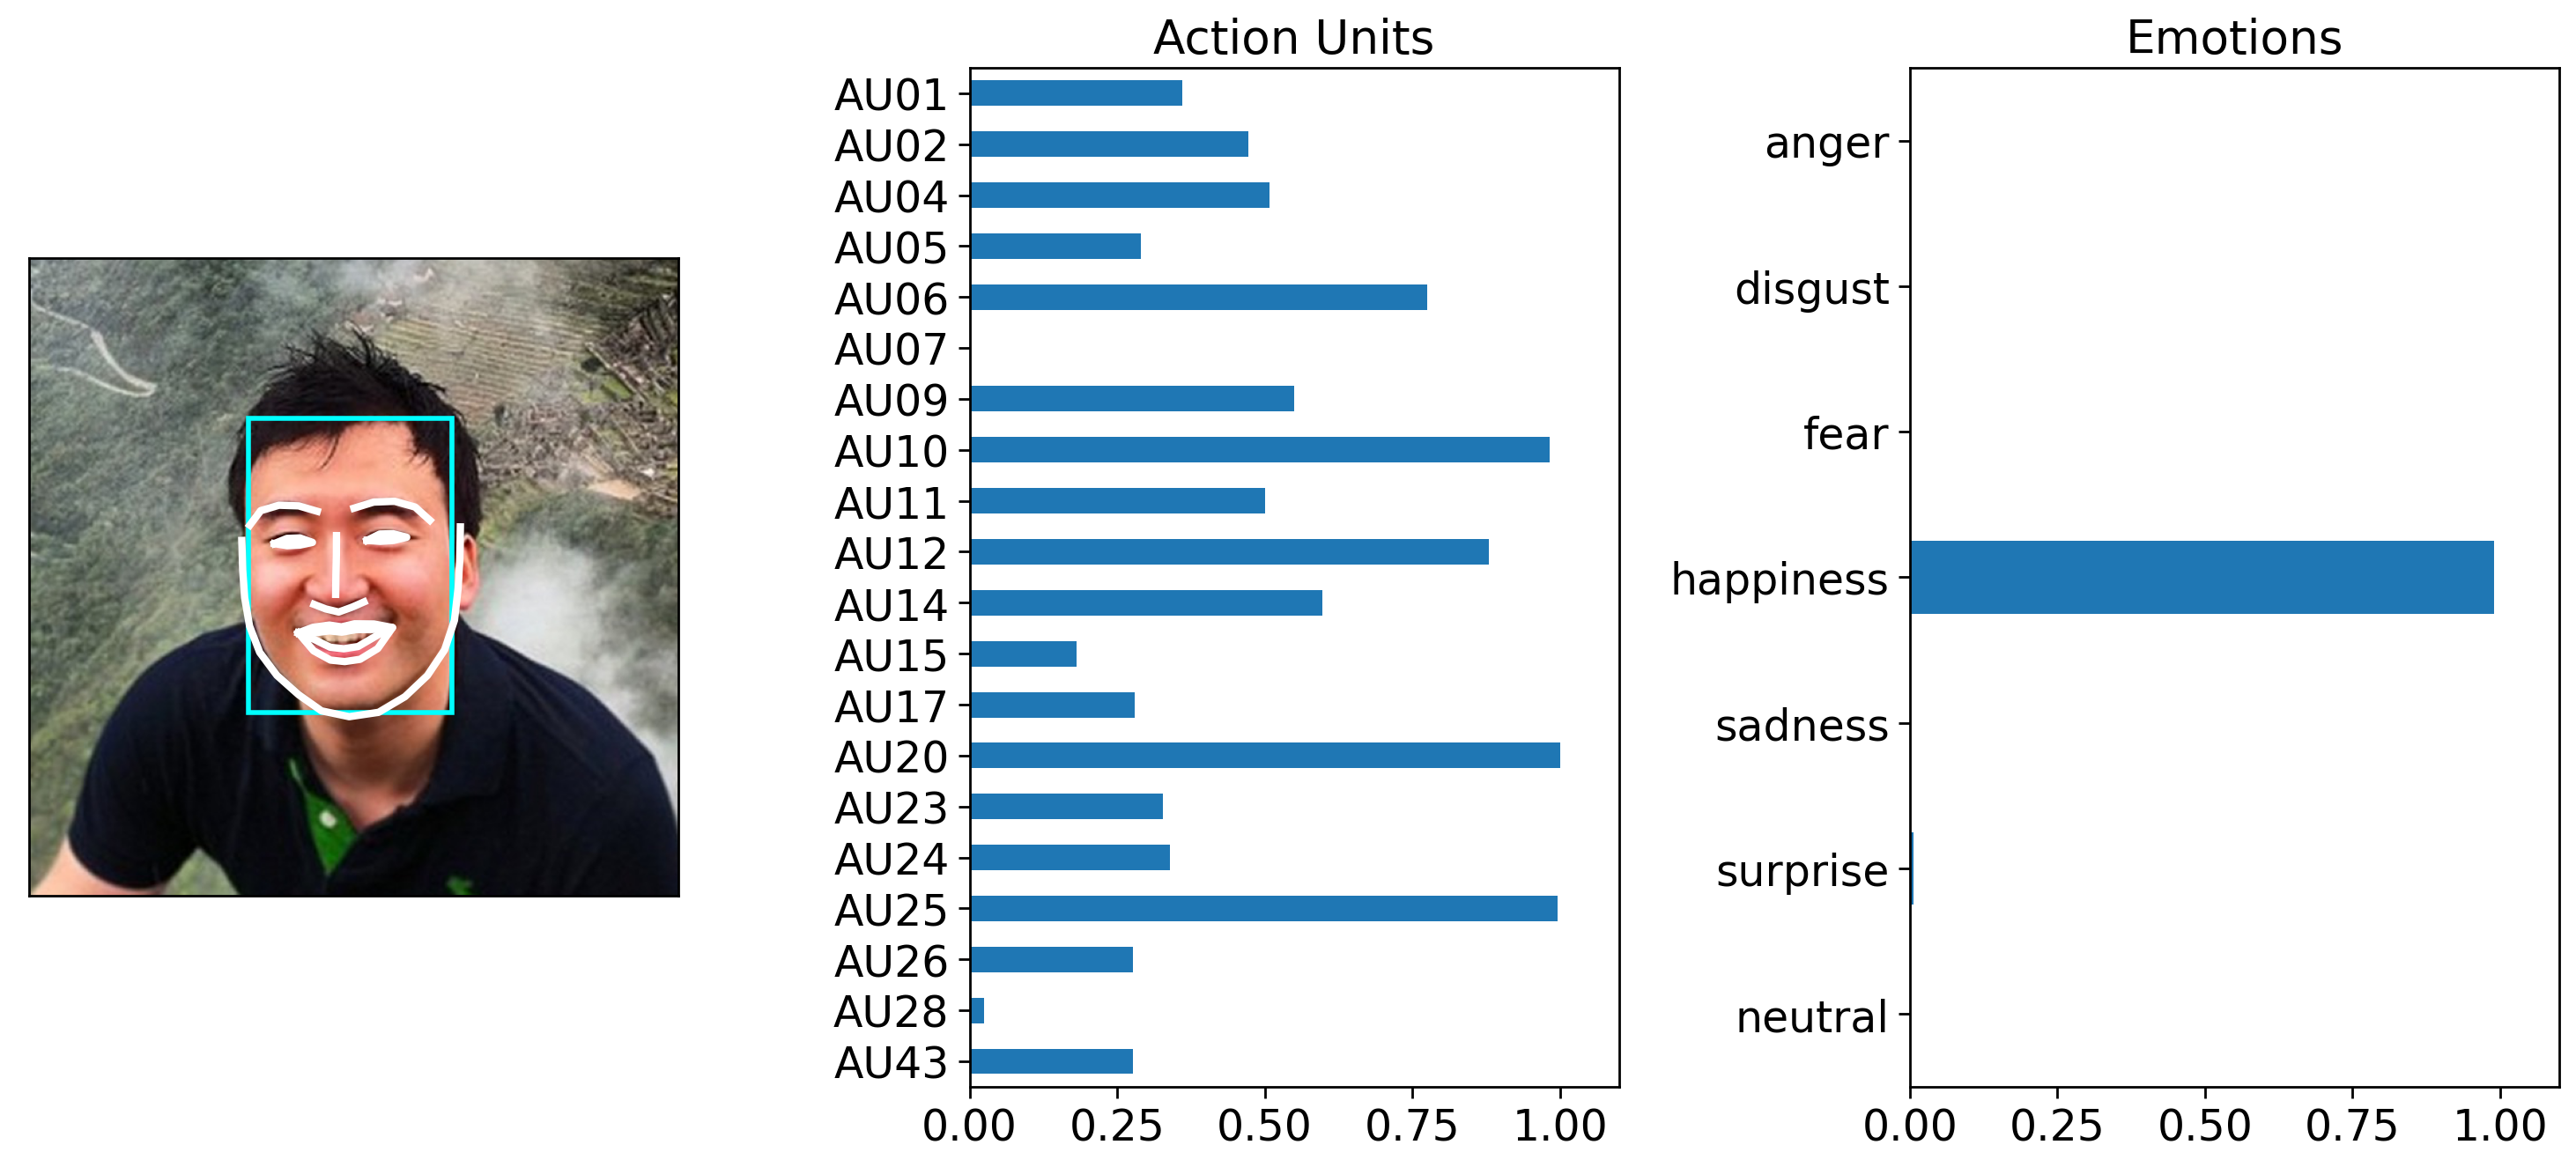

In [16]:
# Just plot the detection corresponding to the first row in the Fex data
figs = mixed_prediction.loc[0].plot_detections(add_titles=False)

Likewise you can use `.query()` and chain it to `.plot_detections()`. `Fex` data classes store each file path in the `'input'` column. So we can use regular pandas methods like `.unique()` to get all the unique images (2 in our case) and pick the second one.

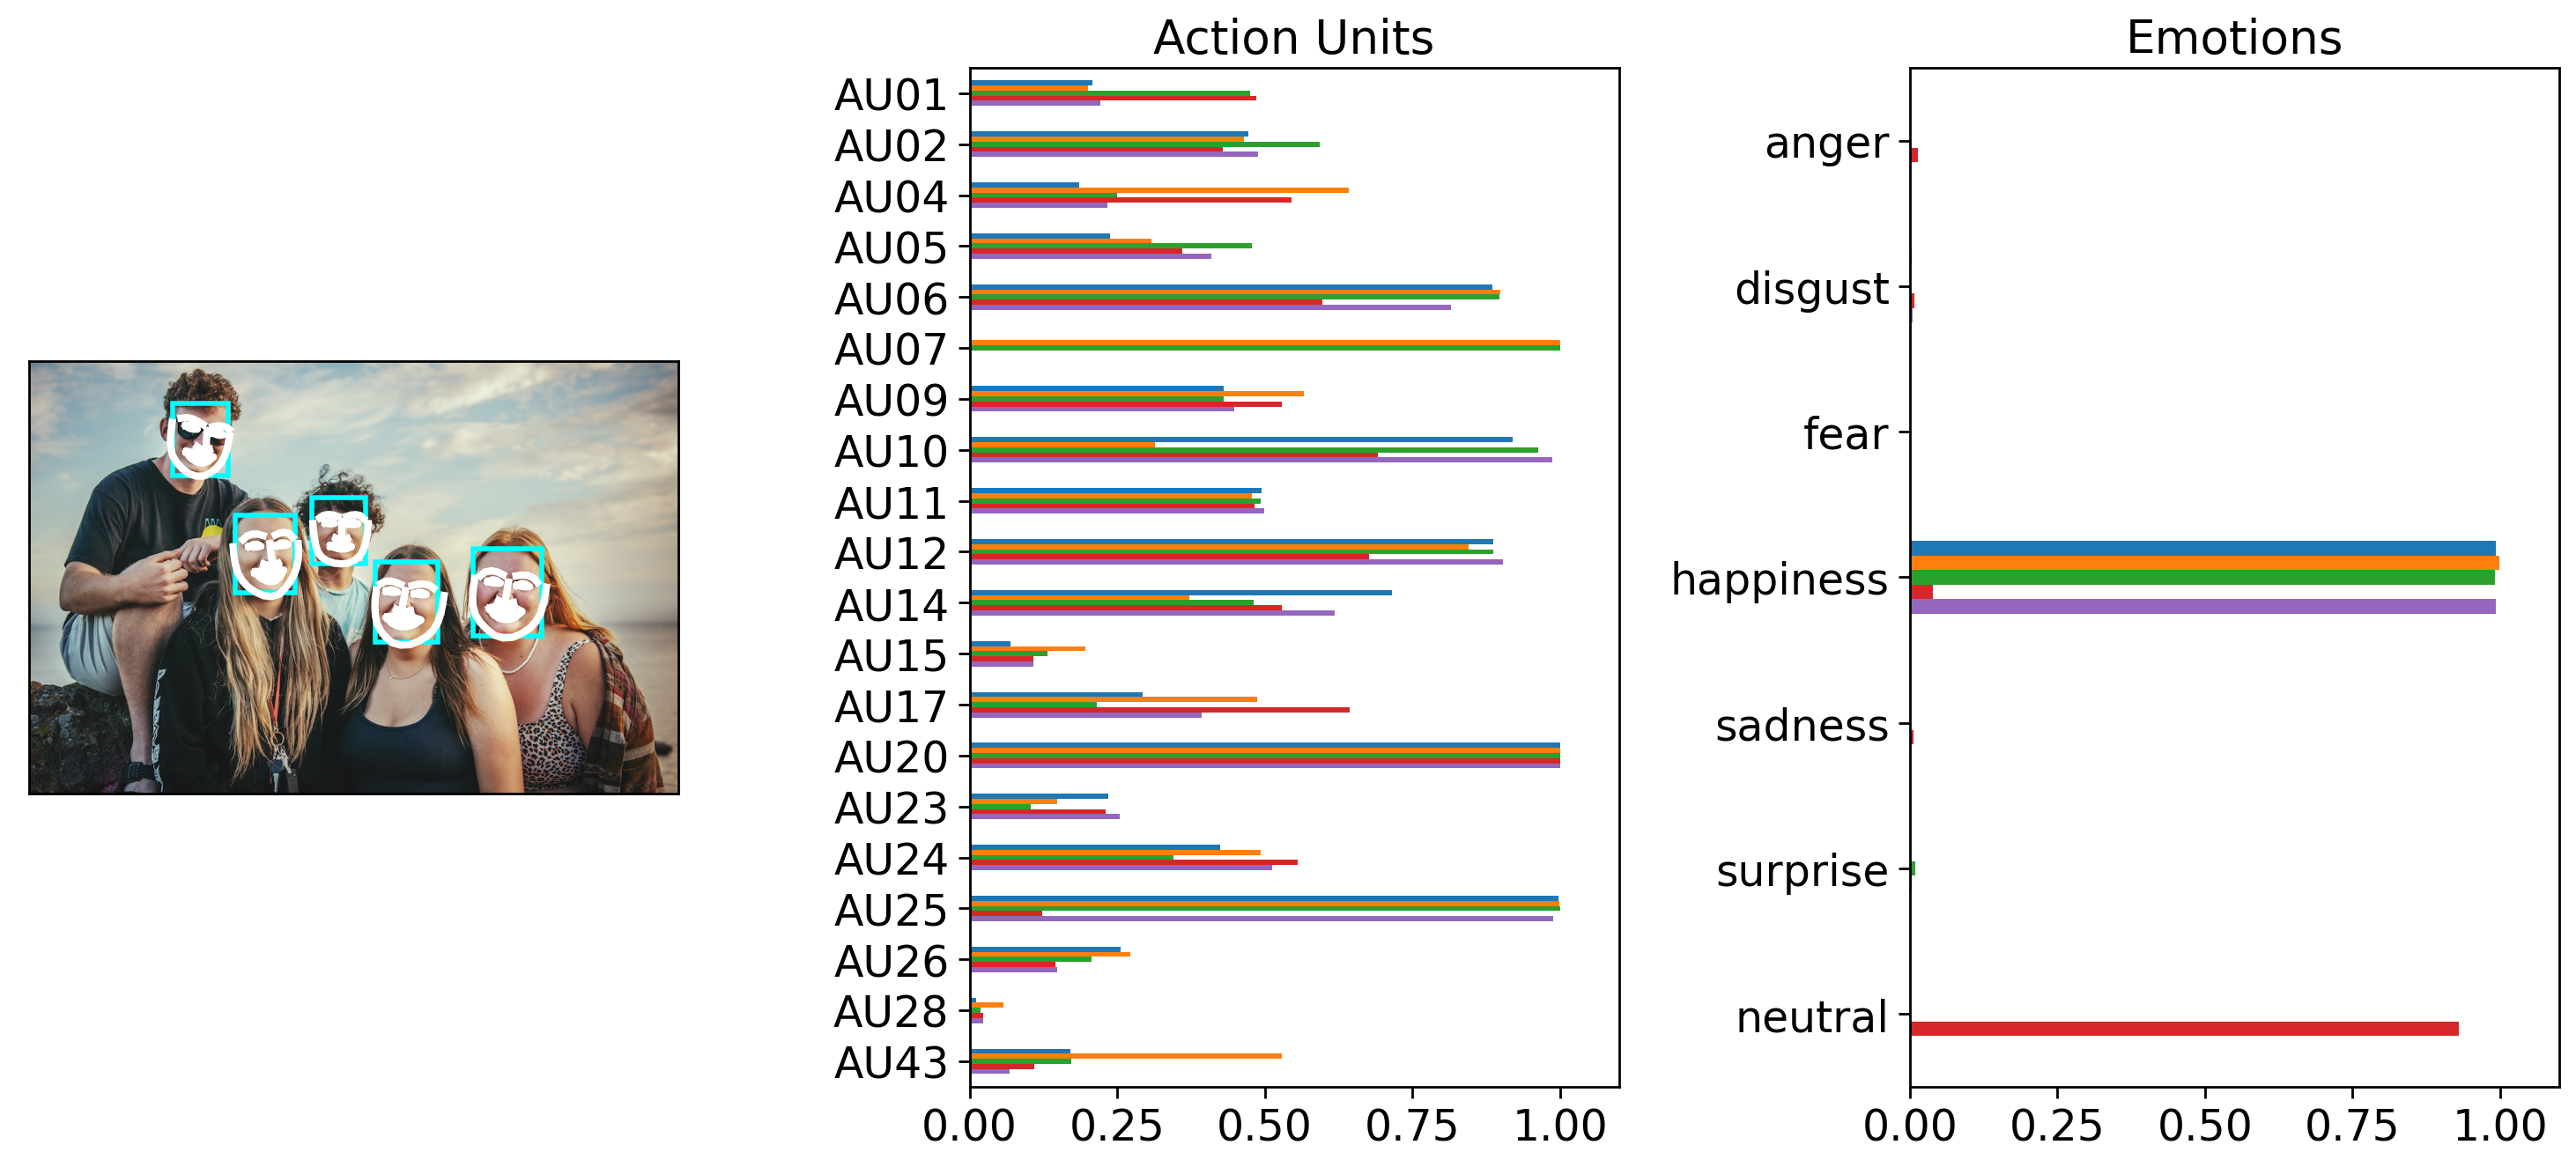

In [17]:
# Choose plot based on image file name
img_name = mixed_prediction['input'].unique()[1]
axes = mixed_prediction.query("input == @img_name").plot_detections(add_titles=False)